# Examples of quantum pulses in TorchQuantum

Author: Jinglei Cheng, 2023

### Introduction

This notebook can be devided into three parts:
1. Example of qubit dynamics with Schrödinger equation solver
2. Example of quantum optimal control with TorchQuantum
3. Example of qubit dynamics with Lindblad master equation solver

### Setup

First, we install the TorchQuantum and import the required functions, etc.

In [1]:
# !git clone https://github.com/mit-han-lab/torchquantum.git
# %cd /content/torchquantum
# !pip install --editable . 1>/dev/null
# !pip install qutip
# !pip install git+https://github.com/rtqichen/torchdiffeq

In [2]:
import torch
import numpy as np
import torchquantum as tq
from torchquantum.pulse import *
import matplotlib.pyplot as plt
from utils import *
from qutip import Bloch

# 1. Schrödinger equation solver for singe qubit dynamics

The Schrödinger equation is $i\hbar\frac{{\partial \Psi}}{{\partial t}} = H \Psi$.

We define an initial state $\psi_0$ as the starting point of the time evolution.

The Hamiltonian of the system is: $H = -\frac{\Omega}{2}V_0s(t)(I\sigma_x + Q\sigma_y)$

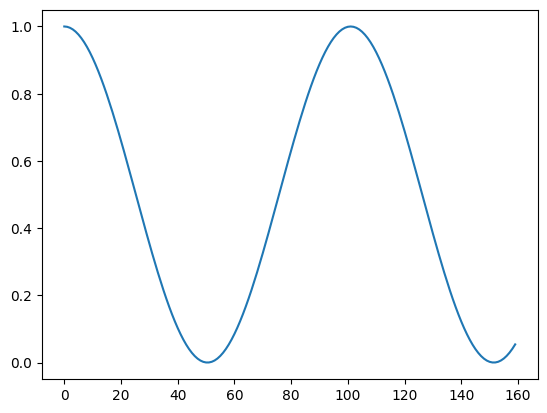

In [3]:
# Number of time slots and length of each slot:
n_dt = 160
dt = 0.22 

# Initialize the state to ground state |0>
# InitialState and InitialDensity are used to define the initial states
psi = InitialState(n_qubit = 1, state = [0])

# The pulse is defined as a constant pulse here
# Schedule() will return a torch.Parameter.parameters variable, 
# which means that we now have access to their gradients
pulse = Schedule((0.1+0.1j) * np.ones((n_dt,1)))

# Hamiltonian is defined 
# It is a time-dependent Hamiltonian, a function of time.
H = H_qubit_example(n_qubit = 1, pulse = pulse, dt = dt)

# Run the Schrödinger equation solver
y_res = sesolve(psi0 = psi, H = H, n_dt = n_dt, dt = dt)

# The results show the evolution of qubit states
psi0_t = torch.abs(y_res[0][:,0]).tolist()

# Plot the probability of state measured as |0>. (on Z basis)
plt.plot([p**2 for p in psi0_t])



## Then we can plot the state on a Bloch Sphere



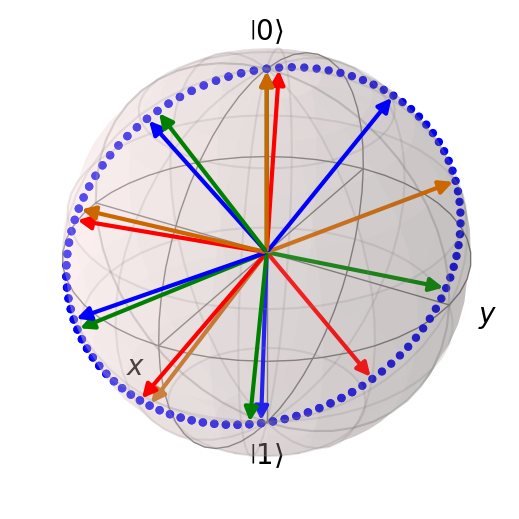

In [4]:
points = [sv2bloch(state) for state in y_res[0].tolist()]
sphere = Bloch()
sphere.add_vectors(points[0])
sphere.add_points(np.array(points).T)
sphere.add_vectors(np.array(points[::10]))
sphere.show()

## When the pulse drive is not constant the qubit would evolve at different speeds, as demonstrated here:

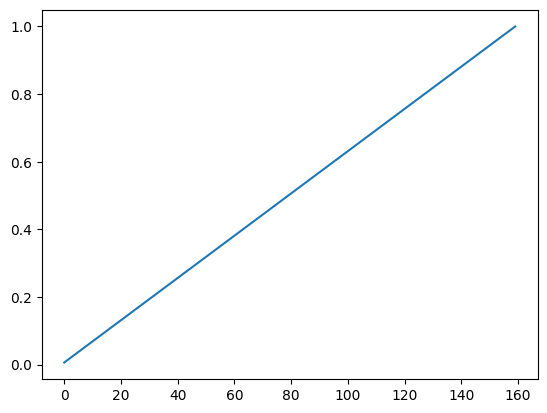

In [5]:
pulse_values = np.arange(1,n_dt+1)/n_dt
pulse = Schedule(pulse_values)

# Here, we have a pulse strength that is linearly increasing.
plt.plot(pulse_values)

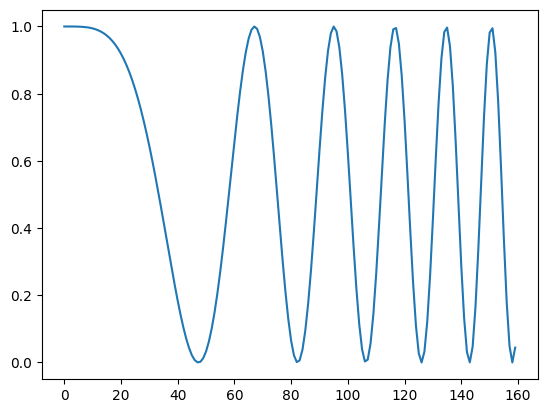

In [6]:
H = H_qubit_example(n_qubit = 1, pulse = pulse, dt = dt)
lin_res = sesolve(psi0 = psi, H = H, n_dt = n_dt, dt = dt)
linpsi0_t = torch.abs(lin_res[0][:,0]).tolist()

#Then we can see that the states are evolving faster with increasing pulse strength
plt.plot([p**2 for p in linpsi0_t])

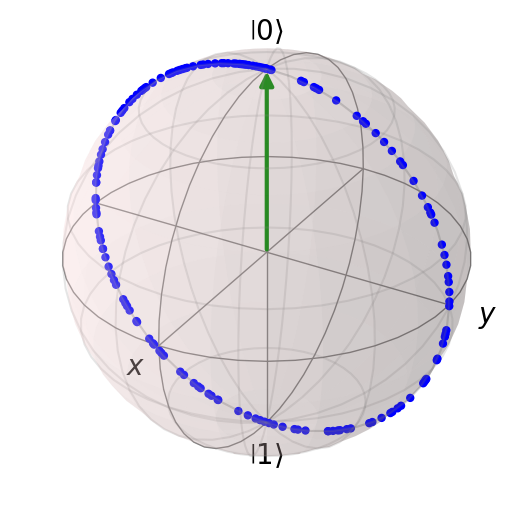

In [7]:
points = [sv2bloch(state) for state in lin_res[0].tolist()]
sphere = Bloch()
sphere.add_vectors(points[0])
sphere.add_points(np.array(points).T)
# sphere.add_vectors(np.array(points[::10]))

# Which can also be seen from the figure, where states are evolving slowly in the beginning
sphere.show()



## Another example of the evolution with cosine pulse strength.



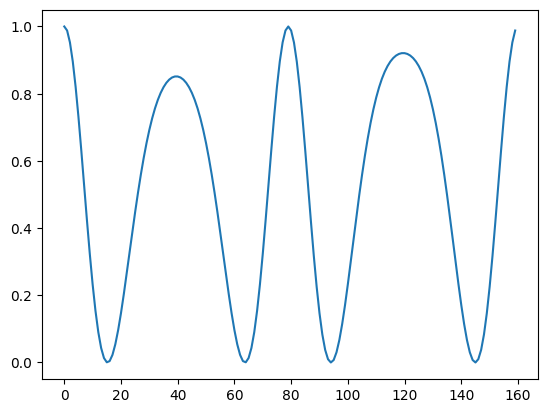

In [8]:
pulse_values = np.cos(2*np.pi/n_dt*np.arange(1,n_dt+1))/2
pulse = Schedule(pulse_values)
H = H_qubit_example(n_qubit = 1, pulse = pulse, dt = dt)
per_res = sesolve(psi0 = psi, H = H, n_dt = n_dt, dt = dt)
perpsi0_t = torch.abs(per_res[0][:,0]).tolist()
plt.plot([p**2 for p in perpsi0_t])

# 2. Optimal control with TorchQuantum

The torch-based solver allows for easy gradients calculation.


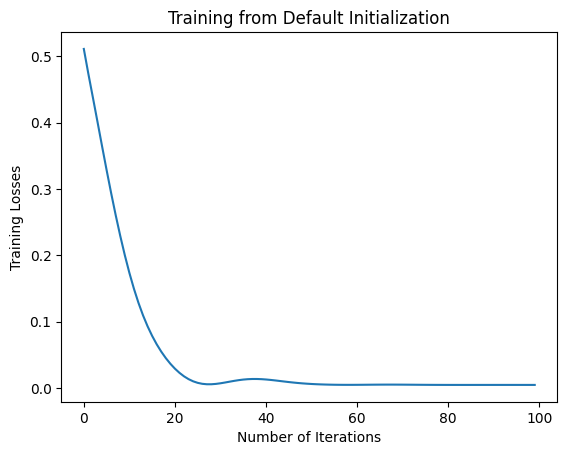

In [9]:
import torch.optim as optim

# The target pulse is composed of 16 segments
n_dt = 16

# The operation is a simple rotation around the x axis
theta = np.pi/4
target_unitary = torch.tensor([[np.cos(theta/2), -1j*np.sin(theta/2)], [-1j*np.sin(theta/2), np.cos(theta/2)]], dtype=torch.complex64)

# Initiliaze the pulse with a constant value
pulse = Schedule((0.1+0.1j) * np.ones((n_dt,1)))

# Define the optimizer as ADAM
optimizer = optim.Adam(params=[pulse], lr=1e-2)

losses = []

for k in range(100):
    
    # Obtain the time-dependent Hamiltonian and the results
    H = H_qubit_example(n_qubit = 1, pulse = pulse, dt = dt)
    solver_result = sesolve(psi0 = sigmai(), H = H, n_dt = n_dt, dt = dt)
    unitary = solver_result[0][-1]
    
    # Compute the loss, the loss function is composed of fidelity, smoothness penalty and "weight" penalty
    loss = 1 - (torch.trace(unitary @ target_unitary) / target_unitary.shape[0]).abs() ** 2 \
    + 0.1 * torch.abs(torch.diff(pulse)).sum() + 0.01 * torch.norm(pulse)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
# Draw the convergence curve
plt.xlabel("Number of Iterations")
plt.ylabel("Training Losses")
plt.title("Training from Default Initialization")
plt.plot(losses[:100])

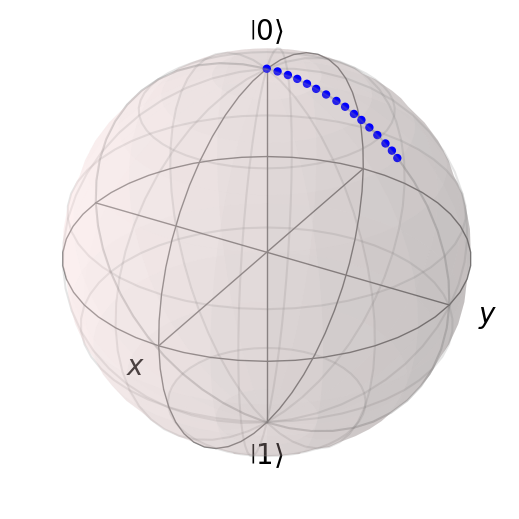

In [10]:
# Here we demosntrate that the results is close to the target unitary

H = H_qubit_example(n_qubit = 1, pulse = pulse, dt = dt)
y_res = sesolve(psi0 = psi, H = H, n_dt = n_dt, dt = dt)
psi0_t = torch.abs(y_res[0][:,0]).tolist()
points = [sv2bloch(state) for state in y_res[0].tolist()]
sphere = Bloch()
sphere.add_points(np.array(points).T)
sphere.show()

# 3. Qubit dynamics with Lindblad master equation


Lindblad equation: $\frac{{d\rho}}{{dt}} = -\frac{{i}}{{\hbar}}[H, \rho] + \sum_{k}\left(L_k\rho L_k^{\dagger} - \frac{1}{2}\{L_k^{\dagger}L_k, \rho\}\right)$

In this equation, $\rho$ represents the density operator, $t$ is the time variable, $\hbar$ is the reduced Planck's constant, $H$ is the Hamiltonian operator, $L_k$ are the Lindblad operators, $\dagger$ denotes the Hermitian conjugate, $[A, B]$ represents the commutator of operators $A$ and $B$, and $\{A, B\}$ represents the anticommutator of operators $A$ and $B$.

## First we demosntrate the single-qubit dynamics without noise, we expect to see the same results as in the Schrodinger equation solver

In [11]:
# First we define the initial Density matrix and the constant pulse
# All settings are the same with the SESolver
n_dt = 160
dt = 0.22 # ns
rho0 = InitialDensity(n_qubit = 1, state = [0])
pulse = Schedule((0.1+0.1j) * np.ones((n_dt,1)))
H = H_qubit_example(n_qubit = 1, pulse = pulse, dt = dt)

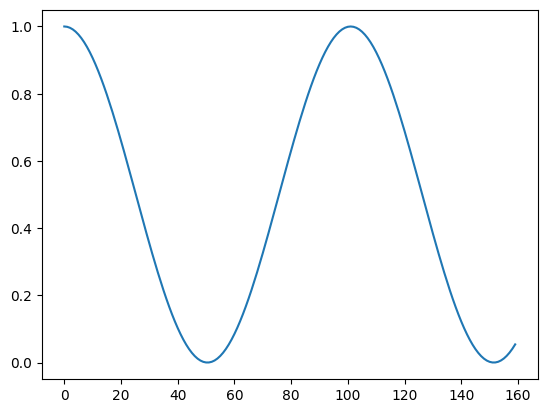

In [12]:
# Here, let's first test the Lindblad equation without L operators
L_ops = None
y_res = mesolve(dens0 = rho0, H = H, n_dt = n_dt, dt = dt, L_ops = L_ops)

# We can see that the curve is exactly the same as the SESolver
plt.plot([torch.diag(p)[0].item().real for p in y_res[0]])

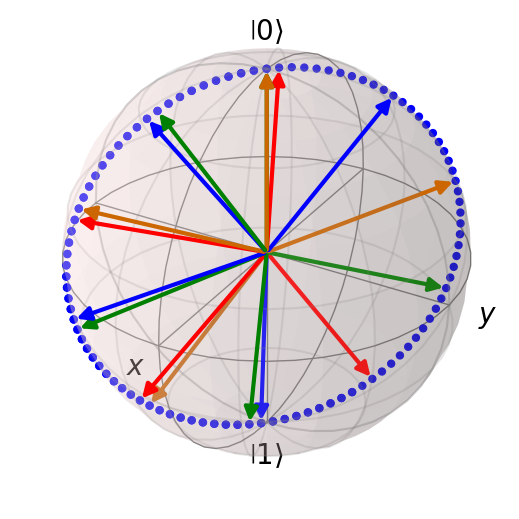

In [13]:
# The bloch sphere is, of course, the same.
points = [dens2bloch(state) for state in y_res[0].tolist()]
sphere = Bloch()
sphere.add_vectors(points[0])
sphere.add_vectors(np.array(points[::10]))
sphere.add_points(np.array(points).T)
sphere.show()

## Then we try to add a dephasing operator $\sigma_z$

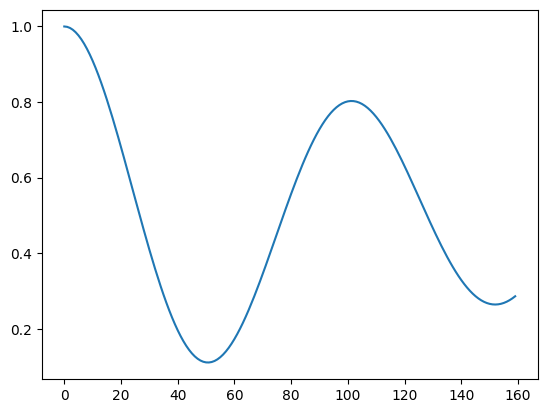

In [14]:
# A dephasing L operator
L_ops = 0.15 * sigmaz()
y_res = mesolve(dens0 = rho0, H = H, n_dt = n_dt, dt = dt, L_ops = L_ops)

# Plot the probability of qubit measured as state |0> (on Z basis)
plt.plot([torch.diag(p)[0].item().real for p in y_res[0]])

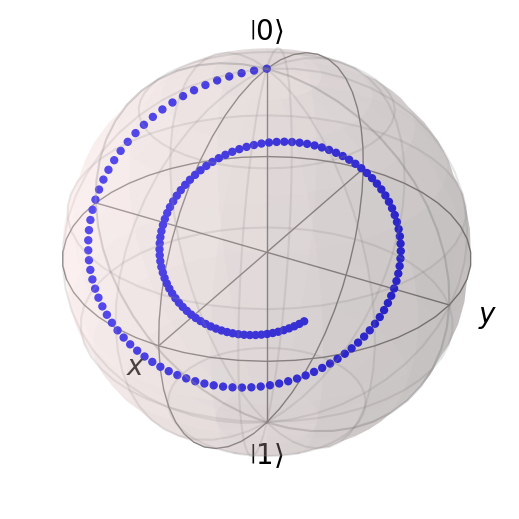

In [15]:
# The figure demonstrates the change of qubit state
points = [dens2bloch(state) for state in y_res[0].tolist()]
sphere = Bloch()
sphere.add_points(np.array(points).T)
sphere.show()

## Dynamics of CR pulse on two qubits

The effective Hamiltonian of CR can be expressed in this way:
$\hat{H} = \frac{\hat{Z}\otimes\hat{A}}{2} + \frac{\hat{I}\otimes\hat{B}}{2}
=a_x\hat{Z}\hat{X} + a_x\hat{Z}\hat{Y}+ a_x\hat{Z}\hat{Z} + a_x\hat{I}\hat{X} + a_x\hat{I}\hat{Y} + a_x\hat{I}\hat{Z}$

In [16]:
# Set the initial state to ground state
rho0 = InitialDensity(n_qubit = 2, state = [0,0])
# state = [target, control]

# Set constant Cross Resonance drive
pulse = Schedule(0.05 * np.ones((n_dt,1)))
H = H_2q_example(pulse = pulse, dt = dt)

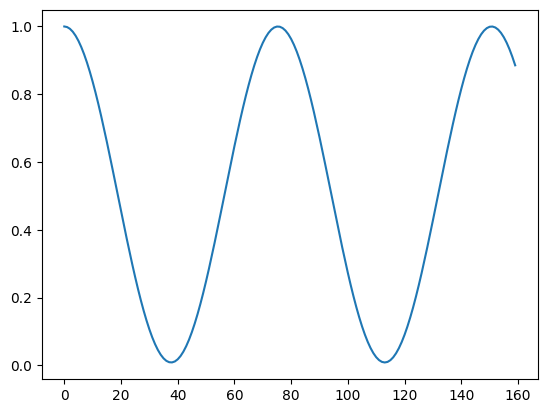

In [17]:
# This picture demosntrates the evolution of target state when control qubit's state is set to 0
L_ops = None
y_res = mesolve(dens0 = rho0, H = H, n_dt = n_dt, dt = dt, L_ops = L_ops)
plt.plot([torch.diag(p)[0].item().real for p in y_res[0]])

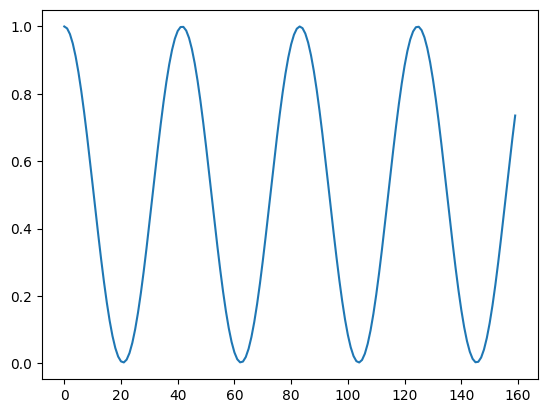

In [18]:
# Set control qubit's state to 1, and see how target qubit evolves:
rho0 = InitialDensity(n_qubit = 2, state = [0,1])
# state = [target, control]
y_res = mesolve(dens0 = rho0, H = H, n_dt = n_dt, dt = dt, L_ops = L_ops)
plt.plot([torch.diag(p)[2].item().real for p in y_res[0]])

## The speed of evolution is different
Then we can use the difference to build controlled gates